In [78]:
import tifffile as tf
from scipy import ndimage
from scipy import spatial
from scipy import signal

import numpy as np
import pandas as pd

import os
import glob
from importlib import reload

import warnings
warnings.filterwarnings( "ignore")
from matplotlib import pyplot as plt
%matplotlib inline

import walnut_utils as wnut
from mvee import EllipsoidTool as ET

In [299]:
fs = 15
resol = 0.0759

mborder = ndimage.generate_binary_structure(3, 1).astype(int)
mborder[mborder == 1] = -1
mborder[1,1,1] = -np.sum(mborder) - 1

wsrc = '../hpcc/clean/'
dst =  '../hpcc/rotated/'

idname = '2012SB'
rownum = 11
treenum = 69
nutnum = 9

bname = idname + '_R{}_T{}'.format(rownum, treenum)
print(bname)

wdst = dst + bname + '/'
if not os.path.isdir(wdst):
    os.makedirs(wdst)
print(wdst)

2012SB_R11_T69
../hpcc/rotated/2012SB_R11_T69/


In [300]:
fname = bname + '_{:03d}'.format(nutnum)
print(fname)

img = tf.imread(wsrc + bname + '/' + fname + '.tif')
mxval = 2**(8*img.itemsize)

nutvol = np.sum(img > 0) * (resol ** 3)

bimg = img.copy().astype(int)
bimg[bimg > 0]  = 1
border = ndimage.convolve(bimg, mborder, mode='constant', cval=0)
border[border < 0] = 0
nutarea = np.sum(border) * (resol ** 2)
border[border > 0] = 1
nutvoxarea = np.sum(border)

2012SB_R11_T69_009


In [301]:
NNN = 30
bottom = img[:NNN,:, :]
top = img[-NNN:, :, :]

In [302]:
topsum = np.sum(top > 0)
botsum = np.sum(bottom > 0)

print('Top:\t', topsum)
print('Bot:\t', botsum,'\n')

if botsum < topsum:
#if botsum > topsum:
    coords = np.asarray(np.nonzero(top))
    tipvox = wnut.find_tip_max(coords, 2,1,0)
    tipvox0 = tipvox.copy()
    tipvox[0] += (img.shape[0] - NNN)
    
    print('Base is at the Bottom\nTipvox:\t', tipvox)
    
else:
    coords = np.asarray(np.nonzero(bottom))
    tipvox = wnut.find_tip_min(coords, 2,1,0)
    tipvox0 = tipvox.copy()
    
    print('Tip is at the Bottom\nTipvox:\t', tipvox)

Top:	 349720
Bot:	 194647 

Base is at the Bottom
Tipvox:	 [537.         190.22222222 154.33333333]


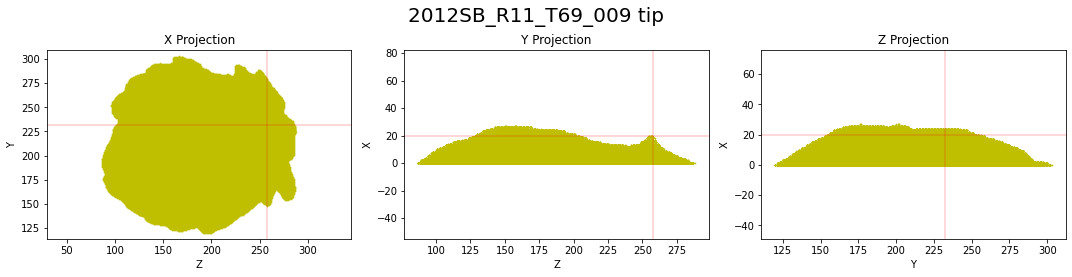

In [310]:
tipvox0 = [20, 232, 258]
fig, ax = wnut.plot_3Dprojections(coords, fname + ' tip', alpha=1, writefig=False, dst=wdst, origin=tipvox0);
tipvox0[0] = img.shape[0] - 2

### Surface area

In [311]:
datapoints = np.asarray(np.nonzero(border))
wmean = np.mean(datapoints, axis = 1)

datapoints = datapoints - wmean.reshape(-1,1)
datapoints *= resol

tipvox = tipvox0 - wmean
tipvox *= resol

rotX, rotY, rotZ = False, False, False
flipx = np.eye(3)

if tipvox[0] < 0:
    rotX = True
    print('rot')
    datapoints[0] *= -1.
    tipvox[0] *= -1.
    flipx[0,0] *= -1

[6.77445141 4.32497347]


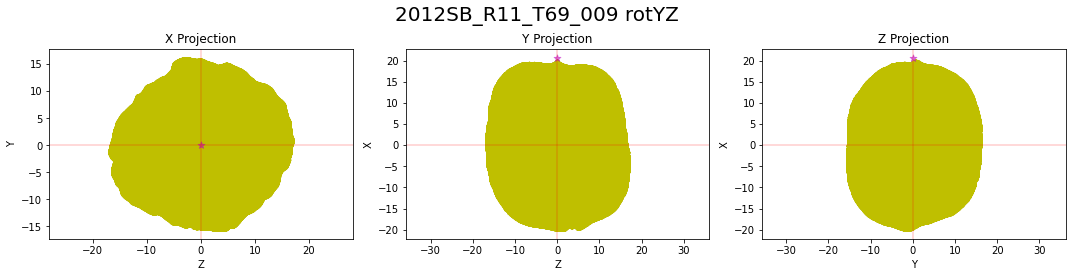

In [312]:
thetay = np.sign(tipvox[1]) * np.arccos(tipvox[0]/np.sqrt(tipvox[0]**2 + tipvox[2]**2))
thetaz = np.sign(tipvox[2]) * np.arccos(tipvox[0]/np.sqrt(tipvox[0]**2 + tipvox[1]**2))
#thetaz += 0.05

print(np.rad2deg([thetay, thetaz]))

roty = np.array([[np.cos(thetay), 0,  np.sin(thetay)],
                 [0, 1, 0],
                 [-np.sin(thetay), 0, np.cos(thetay)]])

rotz = np.array([[np.cos(thetaz), -np.sin(thetaz), 0],
                 [np.sin(thetaz),  np.cos(thetaz), 0],
                 [0, 0, 1]])

rots = [rotz.T @ roty, rotz @ roty.T, rotz.T @ roty, rotz @ roty]
foo = np.zeros(len(rots))

for i in range(len(rots)):
    bar = rots[i] @ tipvox
    foo[i] = np.sum(bar[1:] ** 2)
    
rotyz = rots[np.argmin(foo)]

rcoords = rotyz @ datapoints
rtipvox = rotyz @ tipvox

fig, ax = wnut.plot_3Dprojections(rcoords, fname + ' rotYZ', alpha=1, writefig=False, dst=wdst);
ax[0].scatter(rtipvox[2], rtipvox[1], marker='*', alpha=0.5, s=50, c='m')
ax[1].scatter(rtipvox[2], rtipvox[0], marker='*', alpha=0.5, s=50, c='m')
ax[2].scatter(rtipvox[1], rtipvox[0], marker='*', alpha=0.5, s=50, c='m');

(2, 32338) 
---
PARAMS
---
axes	:
[16.51359647 14.67403507]
origin	:
[0.05720769 0.11498722]
theta	:
0.3451908211689512
rot	:
[[ 0.9410109  -0.33837625]
 [ 0.33837625  0.9410109 ]]
theta	 19.78 deg


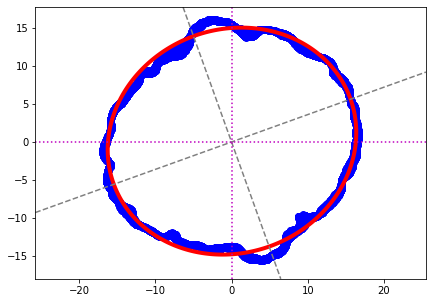

In [313]:
thr = 1
acoords = np.abs(rcoords)
tcoords = np.flip(rcoords[1:, (acoords[0] < thr)])
print(tcoords.shape,'\n---\nPARAMS\n---')

V = wnut.ell_algebraic_fit_2d(*tcoords)
pdict = wnut.get_ell2d_params_from_vector(V)
for key in pdict:
    print(key, '\t:\n', pdict[key], sep='')
print('theta\t',np.round(np.rad2deg(pdict['theta']),2),'deg')

# Plot the noisy data
plt.figure(figsize=(7,5))
plt.scatter(*tcoords, label='Data Points', c='blue')

# Plot the least squares ellipse
x_coord = np.linspace(np.min(tcoords)-1, np.max(tcoords)+1, 300)
y_coord = x_coord
X_coord, Y_coord = np.meshgrid(x_coord, y_coord)
Z_coord = V[0] * X_coord ** 2 + V[1] * X_coord * Y_coord + V[2] * Y_coord**2 + V[3] * X_coord + V[4] * Y_coord
plt.contour(X_coord, Y_coord, Z_coord, levels=[1], colors=('r'), linewidths=4);
plt.axis('equal');

plt.axline(xy1=(0,0), slope = np.tan(pdict['theta']), c='gray', ls='--')
plt.axline(xy1=(0,0), slope = -1/np.tan(pdict['theta']), c='gray', ls='--');

plt.axvline(0, c='m', ls=':')
plt.axhline(0, c='m', ls=':');

In [314]:
Q = pdict['rot'].T @ (tcoords - pdict['origin'].reshape(-1,1))
distances = np.zeros((Q.shape[1], 4))

for i in range(Q.shape[1]):
    distances[i] = wnut.d_ell_point(Q[0,i], Q[1,i], pdict)

P = pdict['rot'] @ (distances[:, 2:].T + pdict['origin'].reshape(-1,1))

phi = np.arccos(distances[:,2]/pdict['axes'][0])
phi[distances[:,3] < 0] = 2*np.pi - phi[distances[:,3] < 0]

stack = wnut.even_space_ell0(721, *pdict['axes'])
idxs = np.digitize(phi, bins=stack[0])
print(np.min(idxs), np.max(idxs))

sumdist = np.zeros(len(stack[0])-1)
for i in range(len(sumdist)):
    sumdist[i] = np.mean(distances[idxs == i+1, 0]*distances[idxs == i+1, 1])
sumdist[sumdist < 0] = 0

if np.argmax(sumdist) < len(sumdist)//2:
    rotZ = True
    print('rot')
    
cval = np.max(np.abs(tcoords))/np.max(sumdist)

1 720
rot


rot
4.945382344753101 283.3495364328638


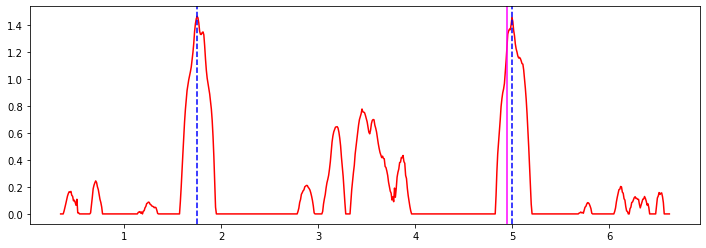

In [315]:
sumdist3 = np.hstack((sumdist,sumdist,sumdist))
rawpeakidx, _ = signal.find_peaks(sumdist3, distance=299)#distance=len(sumdist)//3)
foo = rawpeakidx[(rawpeakidx > len(sumdist)) & (rawpeakidx < 2*len(sumdist))]
srtpeakidx = foo[np.argsort(sumdist3[foo])[-2:][::-1]] - len(sumdist)

thetax = np.mean(stack[0][srtpeakidx]) - np.pi*.5 + pdict['theta']

if rotZ:
    thetax += np.pi
    print('rot')

print(thetax, np.rad2deg(thetax))

plt.figure(figsize=(12,4))
plt.plot(stack[0][:-1] + pdict['theta'], sumdist, c='r');
for x in stack[0][srtpeakidx] + pdict['theta']:
    plt.axvline(x, c='blue', ls='--');
plt.axvline(thetax, c='magenta');

../hpcc/rotated/2012SB_R11_T69/2012SB_R11_T69_009_seal.jpg


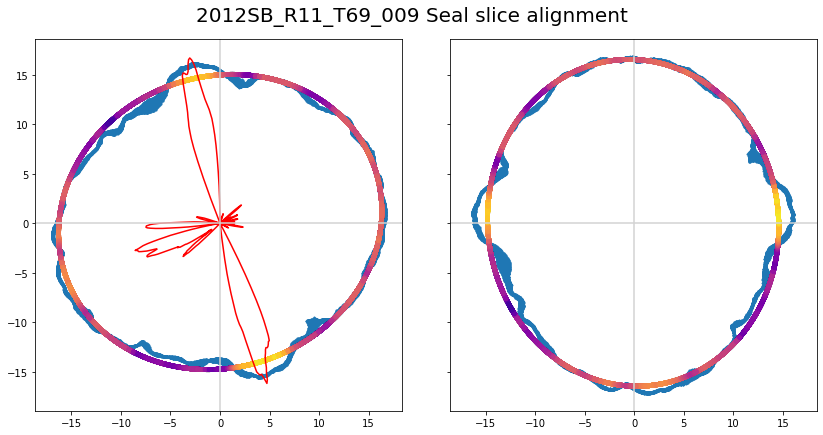

In [316]:
#thetax = (stack[0][srtpeakidx] + pdict['theta'])[0] + np.pi + 0.1
rotx = np.array([[1,0,0], 
                 [0, np.cos(thetax), -np.sin(thetax)],
                 [0, np.sin(thetax),  np.cos(thetax)]])

rotxyz = rotx @ rotyz

bulgerot2d = rotx[1:,1:]

fig, ax = plt.subplots(1,2,figsize=(12,6), sharex=True, sharey=True)

ax[0].scatter(*tcoords, s=1)#, c=distances[:,0]*distances[:,1], cmap='plasma')
ax[0].scatter(*P, s=15, c=distances[:,0]*distances[:,1], cmap='plasma')
ax[0].plot(cval*sumdist*np.cos(stack[0][:-1] + pdict['theta']), cval*sumdist*np.sin(stack[0][:-1] + pdict['theta']), c='r')

ax[1].scatter(*(bulgerot2d.T @ tcoords), s=1)#, c=distances[:,0]*distances[:,1], cmap='plasma')
ax[1].scatter(*(bulgerot2d.T @ P), s=15, c=distances[:,0]*distances[:,1], cmap='plasma')

for i in range(len(ax)):
    ax[i].axvline(0, c= 'lightgray')
    ax[i].axhline(0, c= 'lightgray')
    ax[i].set_aspect('equal');

fig.suptitle(fname + ' Seal slice alignment', fontsize=20)
fig.tight_layout()

filename = wdst + fname + '_seal.jpg'
print(filename)
#plt.savefig(filename, dpi=96, format='jpg', bbox_inches = 'tight', pil_kwargs={'optimize':True})

Tip coords:	 [ 2.072e+01 -0.000e+00  1.000e-02]

[20.13371619 17.12240706 16.35810249]

[40.26743237 34.24481412 32.71620498]


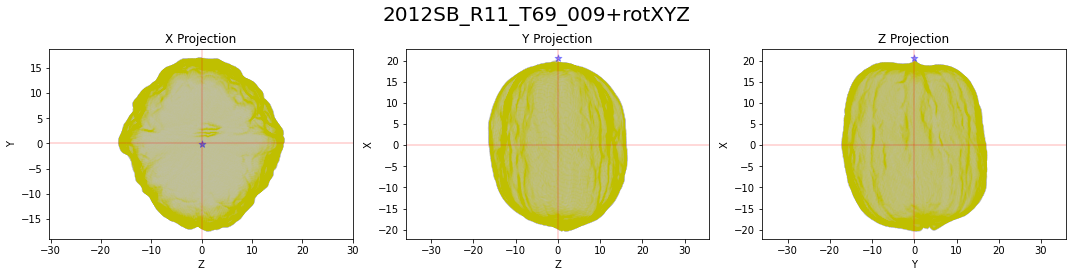

In [317]:
rcoords = rotxyz @ datapoints
rtipvox = rotxyz @ tipvox
print('Tip coords:\t', np.round(rtipvox, 2))

minis = np.min(rcoords, axis=1)
maxes = np.max(rcoords, axis=1)

print('\n', (maxes - minis)/2, '\n\n', maxes - minis, sep='')

fig, ax = wnut.plot_3Dprojections(rcoords, fname + '+rotXYZ', alpha=0.01, writefig=True, dst=wdst);
ax[0].scatter(rtipvox[2], rtipvox[1], marker='*', s=50, c='b', alpha=.4)
ax[1].scatter(rtipvox[2], rtipvox[0], marker='*', s=50, c='b', alpha=.4)
ax[2].scatter(rtipvox[1], rtipvox[0], marker='*', s=50, c='b', alpha=.4);

In [318]:
hull = spatial.ConvexHull(rcoords.T)

align = np.vstack((wmean, rotx, roty, rotz, rotxyz @ flipx,
                   np.array([rotX,rotY,rotZ]).astype(int),
                   tipvox, rtipvox,
                   minis, maxes, maxes - minis,
                   [nutvol, nutarea, nutvoxarea],
                   [hull.area, hull.volume, 0]))
filename = wdst + fname + '_rotation.csv'
print(filename)
np.savetxt(filename, align, delimiter=',')
print(align.shape)

../hpcc/rotated/2012SB_R11_T69/2012SB_R11_T69_009_rotation.csv
(21, 3)
